In [1]:
# Get some code for generating test problems from PyAMG
# PyAMG: https://github.com/pyamg/pyamg
!wget -Nq https://raw.githubusercontent.com/pyamg/pyamg/master/pyamg/gallery/diffusion.py
!wget -Nq https://raw.githubusercontent.com/pyamg/pyamg/master/pyamg/gallery/stencil.py

In [2]:
# Import some python libraries we need
import numpy as np
import matplotlib.pyplot as plt
import stencil
import diffusion
import time
from IPython import display

# Size of the fine-grid and coarse-grid problem
n = 9 # size in 1D
N = n*n # size in 2D

# Create matrix for diffusion problem (using stencil.py and diffusion.py from PyAMG)
sten = diffusion.diffusion_stencil_2d(epsilon=0.001, theta=0.0, type='FD')
A = stencil.stencil_grid(sten, (n, n), format='csr')
# print(A)


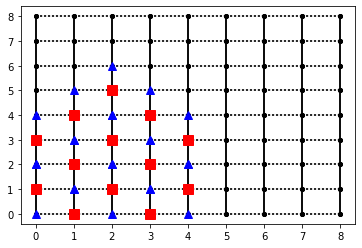

KeyboardInterrupt: 

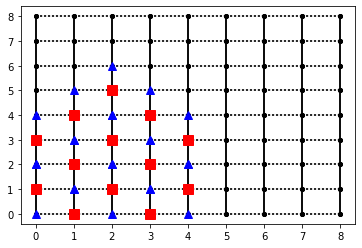

In [3]:
# Set threshold and get row max for A to determine strength of connection later
threshold = 0.25
row_max = np.zeros(N)
for i in range(N):
    x1 = i % n
    y1 = int(i / n)
    for jj in range(A.indptr[i], A.indptr[i+1]):
        j = A.indices[jj]
        if -A.data[jj] > row_max[i] and j != i:
            row_max[i] = -A.data[jj]

# Initialize lambda
lam = np.zeros(N)
for i in range(N):
    for jj in range(A.indptr[i], A.indptr[i+1]):
        j = A.indices[jj]
        if -A.data[jj] >= threshold * row_max[i]:
            lam[i] = lam[i] + 1


# Plot connections in A
threshold = 0.25
cnt = 0
for i in range(N):
    x1 = i % n
    y1 = int(i / n)
    for jj in range(A.indptr[i], A.indptr[i+1]):
        j = A.indices[jj]
        x2 = j % n
        y2 = int(j / n)
        if A.indices[jj] == i:
            plt.plot([x1,x2],[y1,y2],'ok',markersize=4)
        else:
            if -A.data[jj] < threshold * row_max[i]:
                plt.plot([x1,x2],[y1,y2],':k')
            else:
                plt.plot([x1,x2],[y1,y2],'-k')

# Plot progress of coloring scheme
done = 0
while not done:
    
    # Find the max lambda and make it a C-point
    i = np.argmax(lam)
    if lam[i] < 0:
        done = 1
    else:
        x = i % n
        y = int(i / n)
        plt.plot(x,y,'sr',markersize=10)
        lam[i] = -1

        # Make all strongly connected points as F-points
        for jj in range(A.indptr[i], A.indptr[i+1]):
            j = A.indices[jj]
            if -A.data[jj] >= threshold * row_max[i]:
                x = j % n
                y = int(j / n)
                plt.plot(x,y,'^b',markersize=8)
                lam[j] = -1

                # Increment lambda for unmarked connected points
                for kk in range(A.indptr[j], A.indptr[j+1]):
                    k = A.indices[kk]
                    if lam[k] >= 0:
                        lam[k] = lam[k] + 1

    display.clear_output(wait=True)
    display.display(plt.gcf())
    time.sleep(1)
